In [324]:
import pandas as pd
from collections import defaultdict
from numpy import nan, mean, log1p, exp, expm1
from statistics import mode

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)

# Home Data pipeline

See [readme](../README.md) 2do section for next steps

In [325]:
# load data

global column_types, test_data, train_data, full_data
def load_data():
    global column_types, test_data, train_data, full_data
    column_types = defaultdict(lambda: None)
    test_data = pd.read_csv("./test.csv")
    train_data = pd.read_csv("./train.csv")
    full_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

load_data()
full_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,

In [326]:
# define different data transformation functions

is_nan = lambda x: x != x
equals = lambda a, b: (is_nan(a) and is_nan(b)) or a == b
all_unique_values = lambda column_name: set(full_data[column_name].unique())
all_non_nan_values = lambda column_name: set(full_data[column_name].unique())

def drop(column_name="", data_set=None, **_):
    data_set.drop(column_name, axis=1, inplace=True)
    return data_set

def one_hot(column_name="", data_set=None, options={}, **_):
    keys = options if options else all_unique_values(column_name)
    for key in keys:
        column_types[f"{column_name}_{key}"] = "categorical"
        data_set[f"{column_name}_{key}"] = data_set[column_name].apply(lambda x: 1 if equals(x, key) else 0)
    return drop(column_name, data_set)

def apply(fn, column_name="", data_set=None, **_):
    data_set[column_name] = data_set[column_name].apply(fn)
    return data_set

def re_map(mapping, column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    data_set[column_name] = data_set[column_name].apply(lambda x: mapping[x])
    return data_set

def impute(fn=mode, column_name="", data_set=None, **_):
    imputation = fn(full_data[column_name])
    data_set[column_name] = data_set[column_name].apply(lambda x: imputation if is_nan(x) else x)
    return data_set

def MSZoning(column_name="", data_set=None, **_):
    options = dict(
        # A="Agriculture",
        # C="Commercial",
        FV="Floating Village Residential",
        # I="Industrial",
        RH="Residential High Density",
        RL="Residential Low Density",
        # RP="Residential Low Density Park",
        RM="Residential Medium Density",
    )
    for key, name in options.items():
        data_set[f"zoned_{name}"] = data_set[column_name].apply(lambda x: 1 if x in [key, "C (all)"] else 0)
        column_types[f"zoned_{name}"] = "categorical"
    return drop(column_name, data_set)
def MSZoningOld(column_name="", data_set=None, **_):
    options = dict(
        # A="Agriculture",
        # C="Commercial",
        FV="Floating Village Residential",
        # I="Industrial",
        RH="Residential High Density",
        RL="Residential Low Density",
        # RP="Residential Low Density Park",
        RM="Residential Medium Density",
    )
    for key, name in options.items():
        if key == "C":
            continue
        data_set[f"zoned_{name}"] = data_set[column_name].apply(lambda x: 1 if x in [key, "C"] else 0)
        column_types[f"zoned_{name}"] = "categorical"
    return drop(column_name, data_set)

def neighborhood_median(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    neighborhood_medians = full_data[[column_name, "Neighborhood"]].groupby("Neighborhood").median().to_dict()[column_name]
    fn = lambda x: neighborhood_medians[x["Neighborhood"]] if is_nan(x[column_name]) else x[column_name]
    data_set[column_name] = data_set.apply(fn, axis=1)
    return data_set

def PoolQC(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    remap = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1}
    def fn(x):
        if x[column_name] in remap:
            return remap[x[column_name]]
        if x["PoolArea"] > 0:
            return 1 + (x["OverallQual"]-1)*3/9
        return 0
    data_set[column_name] = data_set.apply(fn, axis=1)
    return data_set

def masonry(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    options = dict(
        BrkCmn="Brick Common",
        BrkFace="Brick Face",
        CBlock="Cinder Block",
        Stone="Stone",
    )
    for key in options:
        data_set[f"masonry {options[key]} sqft"] = 0
        for id in range(len(data_set)):
            if data_set[column_name].iloc[id] == key:
                value = data_set["MasVnrArea"].iloc[id]
                # ideally set the above set to the average of that type in that neighborhood (instead of the guess of 75)
                data_set[f"masonry {options[key]} sqft"].iat[id] = value if value > 2 else 75
    
    data_set[f"masonry other sqft"] = 0
    for id in range(len(data_set)):
        if is_nan(data_set["MasVnrType"].iloc[id]) and data_set["MasVnrArea"].iloc[id] > 2:
            data_set["masonry other sqft"].iat[id] = data_set["MasVnrArea"].iloc[id]

    data_set.drop(["MasVnrType", "MasVnrArea"], axis=1, inplace=True)
    return data_set
def masonry_old(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    options = dict(
        BrkCmn="Brick Common",
        BrkFace="Brick Face",
        CBlock="Cinder Block",
        Stone="Stone",
    )
    for key in options:
        data_set[f"masonry {options[key]} sqft"] = 0
        for id in range(len(data_set)):
            if data_set[column_name].iloc[id] == key:
                data_set[f"masonry {options[key]} sqft"].iat[id] = data_set["MasVnrArea"].iloc[id]

    data_set.drop(["MasVnrType", "MasVnrArea"], axis=1, inplace=True)
    return data_set

def fix_basement(data_set=None):
    basement_fields = [b for b in test_data.keys() if "Bsmt" in b]
    for row_id, row in data_set[basement_fields].iterrows():
        any_nulls = row.isnull().any()
        non_nulls = [type(i) == str for i in row]
        non_zeros = [i > 0 if type(i) in [float, int] else False for key, i in row.items()]
        if any_nulls and (any(non_nulls) or any(non_zeros)):
            for key, i in row.items():
                if is_nan(i):
                    data_set.at[row_id, key] = mode(data_set[key].dropna())

def basement(column_name="", data_set=None, **_):
    fix_basement(data_set)
    options = dict(
        GLQ="Good Living Quarters",
        ALQ="Average Living Quarters",
        BLQ="Below Average Living Quarters",
        Rec="Average Rec Room",
        LwQ="Low Quality",
        Unf="Unfinished",
    )
    for key in options:
        data_set[f"basement {options[key]} sqft"] = 0
        column_types[f"basement {options[key]} sqft"] = "numeric"
        for id in range(len(data_set)):
            if data_set["BsmtFinType1"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF1"].iloc[id]
            if data_set["BsmtFinType2"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF2"].iloc[id]
    
    data_set.drop(["BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2"], axis=1, inplace=True)
    return data_set
def basement_old(column_name="", data_set=None, **_):
    options = dict(
        GLQ="Good Living Quarters",
        ALQ="Average Living Quarters",
        BLQ="Below Average Living Quarters",
        Rec="Average Rec Room",
        LwQ="Low Quality",
        Unf="Unfinished",
    )
    for key in options:
        data_set[f"basement {options[key]} sqft"] = 0
        column_types[f"basement {options[key]} sqft"] = "numeric"
        for id in range(len(data_set)):
            if data_set["BsmtFinType1"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF1"].iloc[id]
            if data_set["BsmtFinType2"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF2"].iloc[id]
    
    data_set.drop(["BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2"], axis=1, inplace=True)
    return data_set

def basement_unfinished(column_name="", data_set=None, **_):
    unf1 = "basement Unfinished sqft"
    unf2 = "BsmtUnfSF"
    data_set[unf1] = data_set.apply(lambda x: x[unf1] + x[unf2], axis=1)
    
    data_set.drop(["BsmtUnfSF"], axis=1, inplace=True)
    return data_set

def garage_year(column_name="", data_set=None, **_):
    data_set["GarageYrBlt"] = data_set.apply(lambda x: x["YearBuilt"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"], axis=1)
    return data_set
def garage_year_old(column_name="", data_set=None, **_):
    data_set["GarageYrBlt"] = data_set.apply(lambda x: x["YearRemodAdd"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"], axis=1)
    return data_set

def NA_to_zero(column_name="", data_set=None, **_):
    data_set[column_name] = data_set[column_name].apply(lambda x: 0 if is_nan(x) else x)
    return data_set

def bathz(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    cols = ["BsmtFullBath", "FullBath", "BsmtHalfBath", "HalfBath"]
    for col in cols:
        data_set = NA_to_zero(col, data_set)
    data_set[column_name] = data_set["BsmtFullBath"] + data_set["FullBath"] + 0.5*(data_set["BsmtHalfBath"] + data_set["HalfBath"])
    data_set.drop(cols, axis=1, inplace=True)
    return data_set

def condition12(column_name="", data_set=None, **_):
    conditions = dict(
        Artery="Adjacent to arterial street",
        Feedr="Adjacent to feeder street",
        Norm="Normal",
        RRNn="Within 200' of North-South Railroad",
        RRAn="Adjacent to railroad",
        PosN="Near positive off-site feature",
        PosA="Adjacent to positive off-site feature",
        RRNe="Within 200' of East-West Railroad",
        RRAe="Adjacent to East-West Railroad",
    )
    for condition, label in conditions.items():
        data_set[label] = data_set.apply(lambda x: 1 if condition in [x["Condition1"], x["Condition2"]] else 0, axis=1)
        column_types[label] = "categorical"
    data_set.drop(["Condition1", "Condition2"], axis=1, inplace=True)
    return data_set

def is_new(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YrSold"] == x["YearBuilt"] else 0, axis=1)
    return data_set

def age(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    data_set[column_name] = data_set.apply(lambda x: x["YrSold"] - x["YearRemodAdd"], axis=1)
    return data_set

def remodeled(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YearBuilt"] != x["YearRemodAdd"] else 0, axis=1)
    return data_set

hoods = train_data[["SalePrice", "Neighborhood"]].groupby("Neighborhood").mean().sort_values("SalePrice").index.tolist()
def hood_check(i):
    if i < 3:
        return 0
    if i >= len(train_data["Neighborhood"].unique()) - 3:
        return 2
    return 1
bougieness = {hood: hood_check(i) for i, hood in enumerate(hoods)}

def total_sqft(column_name="", data_set=None, **_):
    data_set[column_name] = data_set["TotalBsmtSF"] + data_set["GrLivArea"]
    data_set.drop(["TotalBsmtSF"], axis=1, inplace=True)
    return data_set

import inflation
def sale_price(column_name="", data_set=None, **_):
    if column_name in data_set:
        data_set[column_name] = data_set.apply(lambda x: inflation.adjust(
                price = x[column_name],
                from_year = x["YrSold"],
                from_month = x["MoSold"],
                to_year = 2010,
                to_month = 7,
            ), axis=1)
    data_set.drop(["MoSold", "YrSold"], axis=1, inplace=True)
    return data_set

def post_sale_price(results, data_set):
    # global original_data
    output = []
    for id, price in enumerate(results):
        id_original = data_set["Id"].iloc[id]
        new_price = inflation.adjust(
            price=price,
            from_year=2010,
            from_month=7,
            to_year=int(full_data["YrSold"][full_data["Id"] == id_original].iloc[0]),
            to_month=int(full_data["MoSold"][full_data["Id"] == id_original].iloc[0]),
        )
        output.append(new_price)
    return results

from scipy.stats import johnsonsu
johnsonsu_fit_params = (-1.5661332502814722, 1.4899652685226785, 93994.93460253121, 55321.66007635476) # a, b, loc, scale
def price_johnson_deskew(column_name="", data_set=None, **_):
    data_set[column_name] = data_set[column_name].apply(lambda x: johnsonsu.cdf(x, *johnsonsu_fit_params))
    return data_set

def price_johnson_reskew(results, _):
    de_skewed = johnsonsu.ppf(results, *johnsonsu_fit_params)
    return [min(train_data["SalePrice"]) if is_nan(x) else abs(x) for x in de_skewed]

def price_normal_deskew(column_name="", data_set=None, **_):
    data_set[column_name] = log1p(data_set[column_name])
    return data_set

def price_normal_reskew(results, _):
    return expm1(results)

def garage_fix(data_set=None, **_):
    if len(data_set[data_set["Id"] == 2127].index):
        id = data_set[data_set["Id"] == 2127].index[0]
        for col in ["GarageFinish", "GarageQual", "GarageCond"]:
            data_set[col].iat[id] = mode(full_data[col])

    if len(data_set[data_set["Id"] == 2577].index):
        id = data_set[data_set["Id"] == 2577].index[0]
        data_set["GarageType"].iat[id] = nan
        data_set["GarageArea"].iat[id] = 0
    return data_set

def drop_outliers(data_set=None, **_):
    for Id in [524, 1299]:
        if len(data_set[data_set["Id"] == Id].index):
            id = data_set[data_set["Id"] == Id].index[0]
            data_set = data_set.drop(id).reset_index(drop=True)
    return data_set

class Transformation:
    def __init__(self,
            column_name=None,
            data_set=None,
            function=None, # required
            args=[],
            kwargs={},
            #metadata
            pre_fit=True, post_fit=False, description="",
        ):
        assert(function)
        self._transformation = dict(column_name=column_name, data_set=data_set, function=function, args=args, kwargs=kwargs)
        self._metadata = dict(pre_fit=pre_fit, post_fit=post_fit, description=description)

    def __getitem__(self, key):
        return (self._transformation | self._metadata)[key]

In [327]:
# specify each column transformation

og_transformations = [
    Transformation(column_name="MSSubClass", function=drop),
    Transformation(column_name="MSZoning", function=MSZoningOld),
    Transformation(column_name="LotFrontage", function=apply, args=[lambda x: 0 if is_nan(x) else x]),
    Transformation(column_name="LandContour", function=re_map, args=[{"Lvl": 1, "Bnk": 3, "HLS": 2, "Low": 0}]),
    Transformation(column_name="LandSlope", function=re_map, args=[{"Gtl": 0, "Mod": 1, "Sev": 2}]),
    Transformation(column_name="Neighborhood", function=one_hot),
    Transformation(column_name="Condition1", function=drop),
    Transformation(column_name="Condition2", function=drop),
    Transformation(column_name="MasVnrType", function=masonry_old),
    Transformation(column_name="BsmtQual", function=re_map, args=[{"Ex": 110, "Gd": 95, "TA": 85, "Fa": 75, "Po": 60, "NA": 0, nan: 0}]),
    Transformation(column_name="BsmtCond", function=drop),
    Transformation(column_name="BsmtExposure", function=re_map, args=[{"Gd": 3, "Av": 2, "Mn": 1, "No": 0, "NA": 0, nan: 0}]),
    Transformation(column_name="TotalBsmtSF", function=basement_old),
    Transformation(column_name="FireplaceQu", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 3}]),
    Transformation(column_name="GarageType", function=one_hot),
    Transformation(column_name="GarageFinish", function=re_map, args=[{"Fin": 2, "RFn": 1, "Unf": 0, "NA": 1, nan: 1}]),
    Transformation(column_name="GarageQual", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NA": 2, nan: 2}]),
    Transformation(column_name="GarageCond", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NA": 2, nan: 2}]),
    Transformation(column_name="PoolQC", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 2, "Fa": 1, nan: 3}]),
    Transformation(column_name="GarageYrBlt", function=garage_year_old),
    Transformation(column_name="SalePrice", function=sale_price),
    Transformation(function=post_sale_price, pre_fit=False, post_fit=True),
]

new_transformations = [
    Transformation(column_name="MSSubClass", function=one_hot),
    Transformation(column_name="MSZoning", function=impute, args=[mode]),
    Transformation(column_name="MSZoning", function=MSZoning),
    Transformation(column_name="LotFrontage", function=neighborhood_median),
    Transformation(column_name="LandContour", function=one_hot),
    Transformation(column_name="LandSlope", function=re_map, args=[{"Gtl": 2, "Mod": 1, "Sev": 0}]),
    Transformation(column_name="Neighborhood", function=re_map, args=[bougieness]),
    Transformation(column_name="Conditions", function=condition12),
    Transformation(column_name="Exterior1st", function=impute, args=[mode]),
    Transformation(column_name="MasVnrType", function=masonry),
    Transformation(column_name="TotalBsmtSF", function=NA_to_zero),
    Transformation(column_name="BsmtUnfSF", function=NA_to_zero),
    Transformation(column_name="BsmtQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="BsmtCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="BsmtExposure", function=re_map, args=[{"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="TotalBsmtSF", function=basement),
    Transformation(column_name="bathz", function=bathz),
    Transformation(column_name="KitchenQual", function=impute, args=[mode]),
    Transformation(column_name="Functional", function=impute, args=[mode]),
    Transformation(column_name="FireplaceQu", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(function=garage_fix, description="fix inconsistent garage values"),
    Transformation(column_name="GarageFinish", function=re_map, args=[{"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="GarageQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="GarageCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="GarageYrBlt", function=garage_year),
    Transformation(column_name="GarageType", function=one_hot, kwargs={"options": all_non_nan_values("GarageType")}),
    Transformation(column_name="PoolQC", function=PoolQC),
    Transformation(column_name="SaleType", function=impute, args=[mode]),
    Transformation(column_name="Age", function=age),
    Transformation(column_name="IsNew", function=is_new),
    Transformation(column_name="YrSold", function=one_hot),
    Transformation(column_name="MoSold", function=one_hot),
    Transformation(column_name="YearRemodAdd", function=drop),
    Transformation(column_name="TotalSqft", function=total_sqft),
    Transformation(column_name="MSSubClass_90", function=drop, description="correlates exactly with BldgType_Duplex"),
    Transformation(column_name="GarageArea", function=drop, description="correlates strongly with GarageCars (which correlates better with SalePrice)"),
    Transformation(column_name="TotRmsAbvGrd", function=drop, description="correlates strongly with GrLivArea (which correlates better with SalePrice)"),
    Transformation(column_name="Age", function=drop, description="correlates strongly with GarageYrBlt (which correlates better with SalePrice)"),
    Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
]

shared_transformations = [
    Transformation(column_name="Street", function=re_map, args=[{"Pave": 1, "Grvl": 0}]),
    Transformation(column_name="Alley", function=drop),
    Transformation(column_name="LotShape", function=re_map, args=[{"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 3}]),
    Transformation(column_name="Utilities", function=drop),
    Transformation(column_name="LotConfig", function=one_hot),
    Transformation(column_name="BldgType", function=one_hot),
    Transformation(column_name="HouseStyle", function=one_hot),
    Transformation(column_name="RoofStyle", function=one_hot),
    Transformation(column_name="RoofMatl", function=one_hot),
    Transformation(column_name="Exterior1st", function=one_hot),
    Transformation(column_name="Exterior2nd", function=drop),
    Transformation(column_name="ExterQual", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}]),
    Transformation(column_name="ExterCond", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}]),
    Transformation(column_name="Foundation", function=one_hot),
    Transformation(column_name="BsmtUnfSF", function=basement_unfinished),
    Transformation(column_name="Heating", function=one_hot),
    Transformation(column_name="HeatingQC", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}]),
    Transformation(column_name="CentralAir", function=re_map, args=[{"Y": 1, "N": 0}]),
    Transformation(column_name="Electrical", function=re_map, args=[{"SBrkr": 4, "FuseA": 3, "FuseF": 2, "FuseP": 1, "Mix": 0, nan: 0}]),
    Transformation(column_name="KitchenQual", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, nan: 0}]),
    Transformation(column_name="Functional", function=re_map, args=[{"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0, nan: 7}]),
    Transformation(column_name="GarageCars", function=NA_to_zero),
    Transformation(column_name="PavedDrive", function=re_map, args=[{"Y": 2, "P": 1, "N": 0}]),
    Transformation(column_name="Fence", function=one_hot),
    Transformation(column_name="MiscFeature", function=drop),
    Transformation(column_name="SaleType", function=one_hot),
    Transformation(column_name="SaleCondition", function=one_hot),
    Transformation(column_name="YearBuilt", function=drop),
]

In [213]:
train_data[train_data.iloc[[10, 78, 457]]["Id"] == ]

10      11
78      79
457    458
Name: Id, dtype: int64

# find correlated variables for dropping

In [89]:
# apply column transformations to data
load_data()
for column_name, (transform, option) in transformations:
    print("transforming", column_name)
    training___data = transform(column_name, training___data, option)
    full_data = transform(column_name, full_data, option)
    validation_data = transform(column_name, validation_data, option)
    test_data = transform(column_name, test_data, option)

validation_data

KeyError: 0

In [9]:
corr = None
corr = full_data.copy()
corr["SalePrice"] = training___price
corr = corr.corr(method="spearman")
corr.dropna(axis=0, how="all", inplace=True)

both_corr = None
both_corr = pd.DataFrame(columns=full_data.keys())
# both_corr = pd.concat([training___data, test_data])
both_corr = pd.concat([both_corr, test_data])
both_corr = both_corr.corr(method="spearman")
both_corr.dropna(axis=0, how="all", inplace=True)

/tmp/ipykernel_18192/2459956485.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  both_corr = pd.concat([both_corr, test_data])


In [10]:
both_corr

,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_20,MSSubClass_85,MSSubClass_90,MSSubClass_30,MSSubClass_160,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_180,MSSubClass_120,MSSubClass_60,MSSubClass_190,zoned_Floating Village Residential,zoned_Residential High Density,zoned_Residential Low Density,zoned_Residential Medium Density,LandContour_HLS,LandContour_Lvl,LandContour_Low,LandContour_Bnk,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LotConfig_Inside,LotConfig_Corner,Adjacent to arterial street,Adjacent to feeder street,Normal,Within 200' of North-South Railroad,Adjacent to railroad,Near positive off-site feature,Adjacent to positive off-site feature,Within 200' of East-West Railroad,Adjacent to East-West Railroad,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_2Story,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_1.5Fin,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_Hip,RoofStyle_Gable,RoofMatl_ClyTile,RoofMatl_WdShake,RoofMatl_Membran,RoofMatl_Roll,RoofMatl_Metal,RoofMatl_WdShngl,RoofMatl_CompShg,RoofMatl_Tar&Grv,Exterior1st_ImStucc,Exterior1st_Wd Sdng,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_CBlock,Exterior1st_AsphShn,Exterior1st_HdBoard,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_Stone,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_WdShing,Exterior1st_CemntBd,masonry Brick Common sqft,masonry Brick Face sqft,masonry Cinder Block sqft,masonry Stone sqft,masonry other sqft,Foundation_Stone,Foundation_PConc,Foundation_Slab,Foundation_Wood,Foundation_CBlock,Foundation_BrkTil,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,bathz,Heating_GasA,Heating_OthW,Heating_Wall,Heating_Floor,Heating_GasW,Heating_Grav,GarageType_Basment,GarageType_Detchd,GarageType_BuiltIn,GarageType_2Types,GarageType_Attchd,GarageType_CarPort,Fence_MnPrv,Fence_MnWw,Fence_GdPrv,Fence_nan,Fence_GdWo,SaleType_COD,SaleType_WD,SaleType_ConLw,SaleType_CWD,SaleType_Oth,SaleType_Con,SaleType_ConLI,SaleType_New,SaleType_ConLD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_Partial,Age,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalSqft
Id,1.000000,-0.017864,0.011641,0.003001,0.002316,0.009410,-0.098702,-0.066390,0.007193,-0.071361,-0.021450,-0.056173,-0.022073,0.051018,-0.028770,-0.036594,-0.037375,-0.015600,-0.011467,0.002839,-0.041460,0.009060,-0.017051,-0.062399,-0.000997,-0.067446,-0.045993,-0.046673,-0.056502,-0.041034,-0.056270,-0.046637,-0.054069,-0.037122,-0.030846,-0.007128,-0.022590,0.022598,-0.021769,0.036491,0.041897,0.041798,-0.019466,0.024766,0.010951,0.005425,-0.017664,0.025158,-0.011876,0.000662,-0.026834,0.027710,-0.002085,0.021854,0.046607,-0.039304,-0.000416,0.027422,-0.063453,-0.007587,0.028164,0.033953,0.040372,-0.042825,0.023912,0.006672,-0.030510,0.019770,0.017101,0.005003,-0.008778,-0.023622,0.016624,-0.009196,-0.041300,0.042668,-0.044800,0.024361,-0.009274,0.011282,0.021059,0.027196,-0.011876,-0.008663,-0.029874,0.016971,0.048874,-0.017265,0.025006,-0.028026,NaN,0.027790,0.007798,0.004734,0.000019,-0.026298,0.048930,-0.011553,0.008229,NaN,0.006

In [11]:
indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")
high_corr

,SalePrice,TotalSqft,OverallQual,GrLivArea,bathz,GarageCars,ExterQual,BsmtQual,KitchenQual,GarageArea,GarageFinish,GarageYrBlt,1stFlrSF,Age,Foundation_PConc,FireplaceQu,TotRmsAbvGrd,Fireplaces,Neighborhood,HeatingQC
SalePrice,1.000000,0.817010,0.806191,0.728611,0.707473,0.693171,0.687651,0.679100,0.664711,0.660863,0.631722,0.628610,0.593669,-0.578841,0.570677,0.541127,0.525533,0.524199,0.509403,0.500527
TotalSqft,0.817010,1.000000,0.655684,0.869057,0.610746,0.573071,0.524066,0.507785,0.496593,0.565760,0.457168,0.385595,0.753769,-0.356228,0.381773,0.502548,0.676489,0.493839,0.450966,0.334766
OverallQual,0.806191,0.655684,1.000000,0.603262,0.557466,0.608756,0.715988,0.673048,0.660498,0.541552,0.567090,0.622280,0.408730,-0.563396,0.586764,0.481197,0.427806,0.420626,0.464701,0.473591
GrLivArea,0.728611,0.869057,0.603262,1.000000,0.604521,0.505094,0.446430,0.388268,0.427784,0.468211,0.388025,0.293149,0.494421,-0.290551,0.332373,0.480506,0.827874,0.480804,0.362957,0.283599
bathz,0.707473,0.610746,0.557466,0.604521,1.000000,0.529361,0.494642,0.562690,0.487101,0.493908,0.495813,0.498576,0.358812,-0.415571,0.446188,0.311082,0.453237,0.344650,0.351536,0.338435
GarageCars,0.693171,0.573071,0.608756,0.505094,0.529361,1.000000,0.542498,0.551884,0.520308,0.853317,0.548214,0.648543,0.450580,-0.463009,0.480178,0.357182,0.386244,0.325520,0.432260,0.343988
ExterQual,0.687651,0.524066,0.715988,0.446430,0.494642,0.542498,1.000000,0.645766,0.725266,0.484655,0.536103,0.662905,0.337444,-0.633348,0.632657,0.352144,0.300065,0.262436,0.459916,0.552073
BsmtQual,0.679100,0.507785,0.673048,0.388268,0.562690,0.551884,0.645766,1.000000,0.575112,0.464520,0.555535,0.723384,0.301489,-0.591744,0.663624,0.317001,0.224725,0.262486,0.388138,0.453746
KitchenQual,0.664711,0.496593,0.660498,0.427784,0.487101,0.520308,0.725266,0.575112,1.000000,0.484536,0.480438,0.600192,0.340988,-0.659362,0.567626,0.348324,0.285377,0.264540,0.403901,0.532787
GarageArea,0.660863,0.565760,0.541552,0.468211,0.493908,0.853317,0.484655,0.464520,0.484536,1.000000,0.474226,0.616982,0.489797,-0.400177,0.400205,0.288576,0.330549,0.264543,0.394443,0.296423


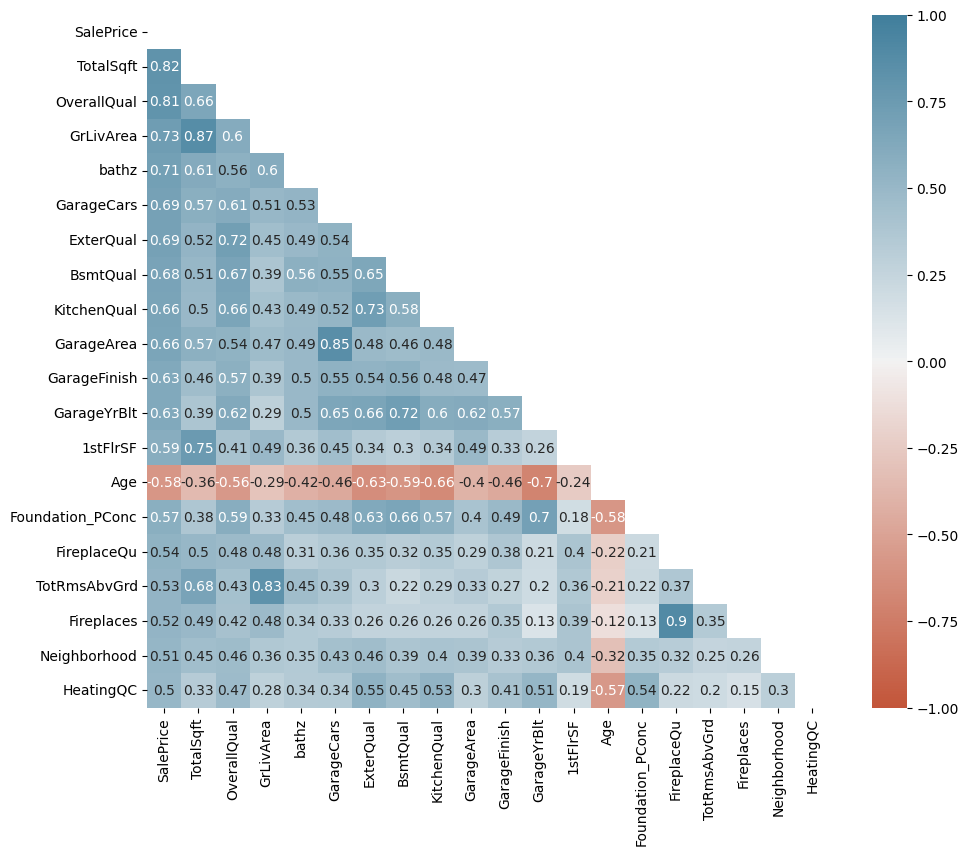

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")

plt.subplots(figsize=(11, 9))
sns.heatmap(high_corr,
    mask=np.triu(np.ones_like(high_corr, dtype=bool)),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    vmax=1, vmin=-1, center=0,
    annot=True,
)
None

In [24]:
output = pd.DataFrame(columns=["column1 (& type)", "column2 (& type)", "correlation"])

correlations = dict()
for col1, item in dict(both_corr).items():
    for col2, value in dict(item).items():
        if col1 == col2:
            continue
        key1, key2 = sorted([col1, col2])
        correlations[(key1, key2)] = value

correlations = sorted(correlations.items(), reverse=True, key=lambda x: abs(x[1]))
limit = 20
n = 0
for (key1, key2), value in correlations:
    if n >= limit:
        break
    if "categorical" in [column_types[key1], column_types[key2]]:
        continue
    output.loc[n] = [f"{key1} ({column_types[key1] or 'numeric'})", f"{key2} ({column_types[key2] or 'numeric'})", value]
    n += 1
output

,variable1 (& type),variable2 (& type),correlation
0,PoolArea (numeric),PoolQC (ordinal),0.999991
1,TotalSqft (numeric),bathz (ordinal),0.629003
2,basement Good Living Quarters sqft (numeric),bathz (ordinal),0.560343
3,Age (ordinal),bathz (ordinal),-0.477695
4,Age (ordinal),basement Good Living Quarters sqft (numeric),-0.422892
5,TotalSqft (numeric),basement Good Living Quarters sqft (numeric),0.362227
6,TotalSqft (numeric),basement Unfinished sqft (numeric),0.356479
7,TotalSqft (numeric),masonry Brick Face sqft (numeric),0.319460
8,Age (ordinal),basement Average Rec Room sqft (numeric),0.266273
9,basement Average Living Quarters sqft (numeric),basement Good Living Quarters sqft (numeric),-0.252059


In [14]:
drop_correlated_columns = [
    "Id", # not useful
    "MSSubClass_90", # correlates exactly with BldgType_Duplex
    "GarageArea", # correlates strongly with GarageCars (which correlates better with SalePrice)
    "TotRmsAbvGrd", # correlates strongly with GrLivArea (which correlates better with SalePrice)
    # "Age", # correlates strongly with GarageYrBlt (which correlates better with SalePrice)
]

# Find sparse data for dropping

In [15]:
columns_with_same_val = set([col for col in full_data.columns if len(full_data.index) - max(full_data[col].value_counts()) < 20 or len(test_data.index) - max(test_data[col].value_counts()) < 20])
output = pd.DataFrame(columns=["column", "type", "training occurrences", "test occurrences", "mode", "decision", "total"])
drop_saturated_columns = []
for i, col in enumerate(columns_with_same_val):
    non_similar_full = len(full_data.index) - max(full_data[col].value_counts())
    non_similar_test = len(test_data.index) - max(test_data[col].value_counts())
    # dr0p = non_similar_full == 0 or non_similar_test == 0 or non_similar_full + non_similar_test < 19 and column_types[col] == "categorical"
    dr0p = non_similar_full == 0 or non_similar_test == 0
    popular_value = full_data[col].value_counts().idxmax()
    output.loc[i+1] = [col, column_types[col], non_similar_full, non_similar_test, popular_value, "🔪" if dr0p else "👍", non_similar_full + non_similar_test]
    if dr0p:
        drop_saturated_columns.append(col)
output.sort_values("total").reset_index(drop=True)

,column,type,training occurrences,test occurrences,mode,decision,total
0,masonry Cinder Block sqft,None,0,0,0,🔪,0
1,RoofMatl_ClyTile,categorical,1,0,0,🔪,1
2,RoofMatl_Metal,categorical,1,0,0,🔪,1
3,Heating_Floor,categorical,1,0,0,🔪,1
4,RoofMatl_Roll,categorical,1,0,0,🔪,1
5,RoofMatl_Membran,categorical,1,0,0,🔪,1
6,Exterior1st_ImStucc,categorical,1,0,0,🔪,1
7,Exterior1st_CBlock,categorical,1,1,0,👍,2
8,Exterior1st_AsphShn,categorical,1,1,0,👍,2
9,Exterior1st_Stone,categorical,2,0,0,🔪,2


In [26]:
drop_columns = list(set(["Id"] + drop_correlated_columns + drop_saturated_columns))
print(f"dropping the following {len(drop_columns)} columns:")
for col in drop_columns:
    print("  -", col)

dropping the following 14 columns:
  - Exterior1st_Stone
  - Id
  - masonry Cinder Block sqft
  - HouseStyle_2.5Fin
  - MSSubClass_90
  - GarageArea
  - RoofMatl_Membran
  - TotRmsAbvGrd
  - RoofMatl_ClyTile
  - RoofMatl_Roll
  - Exterior1st_ImStucc
  - Heating_Floor
  - Heating_OthW
  - RoofMatl_Metal


# Fit, cross-validate, & compare

Root Mean Squared Error for log_e of "johnsonsu+new" scheme: $ 19.73 ± 0.27 k
Root Mean Squared Error for log_e of "normalize+new" scheme: $ 19.44 ± 0.16 k
Root Mean Squared Error for log_e of "og (without hack)" scheme: $ 19.80 ± 0.36 k
Root Mean Squared Error for log_e of "new" scheme: $ 19.42 ± 0.20 k


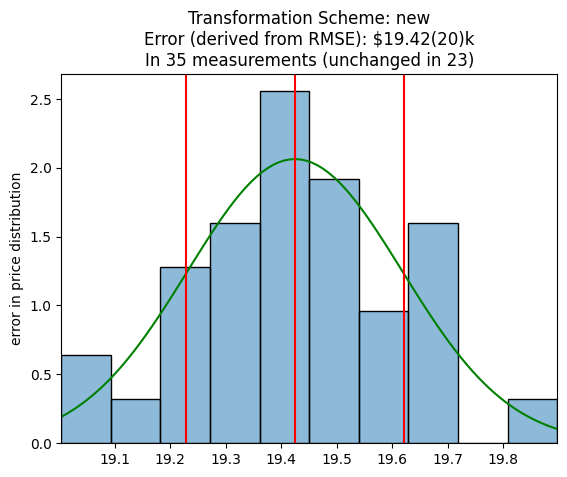

In [331]:
from xgboost import XGBRegressor
from sigfig import round
from sklearn.metrics import root_mean_squared_error
from capture_output import Capturing
from random import shuffle
from numpy import linspace, log10, sqrt
from IPython import display
from statistics import stdev as _stdev
from scipy.stats import norm, ks_1samp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

def stdev(data):
    try:
        return _stdev(data)
    except:
        return 0
def price_plot(errors=[], streak=0, label=""):
    base_plot = sns.histplot(pd.DataFrame(errors), legend=False, bins=10, stat='density')

    fit = norm
    x = linspace(*base_plot.get_xlim(), 100)
    y = fit.pdf(x, *fit.fit(errors))
    p = ks_1samp(errors, fit(*fit.fit(errors)).cdf).pvalue
    plt.plot(x, y, color="g", label=f"{fit.name} fit (p≈$10^{{{int(log10(p))}}}$)")

    plt.axvline(x = mean(errors), color = 'r')
    plt.axvline(x = mean(errors) + stdev(errors), color = 'r')
    plt.axvline(x = mean(errors) - stdev(errors), color = 'r')
    title = [
        f"Transformation Scheme: {label}" if label else "",
        f"Error (derived from RMSE): \${round(mean(errors), stdev(errors), format='Drake')}k",
        f"In {len(errors)} measurements{f' (unchanged in {streak}' if streak else ''})",
    ]
    base_plot.set_title("\n".join([t for t in title if t]))
    base_plot.set_ylabel('error in price distribution')
    base_plot.set_xlim(min(errors), max(errors))
def update_price_plot(errors, label="", streak_length=None):
    try:
        plt.cla()
        price_plot(errors=errors, streak=streak_length, label=label)
        display.display(plt.gcf())
        display.clear_output(wait=True)
    except:
        None

def generate_cross_validation_sets(full_data, sets=5):
    indicies = [i for i in range(len(full_data))]
    shuffle(indicies)
    set_size = len(full_data) // sets
    for n in range(sets):
        yield sorted(indicies[n*set_size:(n+1)*set_size])

def cross_validate(data, test_indicies, post_transformations=[]):
    training_data = data.drop(test_indicies).drop(["SalePrice", "Id"], axis=1)
    training_price = data["SalePrice"].drop(test_indicies)
    # training_price = train_data["SalePrice"].drop(test_indicies) # the hack that makes og work so well
    validation_data = data.iloc[test_indicies]
    validation_price = data["SalePrice"].iloc[test_indicies]
    # validation_price = train_data["SalePrice"].iloc[test_indicies] # the hack that makes og work so well
    validation_price_original = train_data[train_data["Id"].isin(data.iloc[test_indicies]["Id"])]["SalePrice"]

    model = None
    model = XGBRegressor(n_estimators=1_000, learning_rate=0.05, early_stopping_rounds=5)
    with Capturing() as output:
        model.fit(training_data, training_price, eval_set=[(validation_data.drop(["SalePrice", "Id"], axis=1), validation_price)])

    predictions = model.predict(validation_data.drop(["SalePrice", "Id"], axis=1))
    for transformation in post_transformations:
        predictions = transformation["function"](predictions, validation_data)

    error = float(root_mean_squared_error(log1p(validation_price_original), log1p(predictions)))

    error_in_dollars = exp(error) * sqrt(len(predictions))

    x = pd.DataFrame({"vpo": validation_price_original, "predict": predictions})
    x["% error"] = abs((x["vpo"] - x["predict"])/x["vpo"]*100)
        
    return {"error": error_in_dollars, "iterations": len(output), "baddies": x["% error"].to_dict()}

def transform_data(transformations, data_set=train_data):
    data = data_set.copy()
    post_transformations = []
    for transformation in transformations:
        if transformation["post_fit"]:
            post_transformations.append(transformation)
        if not transformation["pre_fit"]:
            continue
        data = transformation["function"](*transformation["args"], data_set=data, column_name=transformation["column_name"], **transformation["kwargs"])
    return data, post_transformations

def benchmark(data, post_transformations, time_limit=timedelta(minutes=15), streak_limit=20, verbose=True, validation_sets=5, label=""):
    streak = {"value": 0, "length": 0}
    start_time = datetime.now()
    errors = []
    baddies = defaultdict(lambda: [])
    while True:
        if streak["length"] > streak_limit:
            break
        time_elapsed = datetime.now() - start_time
        if time_elapsed > time_limit:
            break
        for test_indicies in generate_cross_validation_sets(data, sets=validation_sets):
            results = cross_validate(data, test_indicies, post_transformations=post_transformations)
            errors.append(results["error"])
            for key, value in results["baddies"].items():
                baddies[key + 1].append(value)
            cumulative_error = round(mean(errors), stdev(errors), sep=tuple)
            if cumulative_error == streak["value"]:
                streak["length"] += 1
            else:
                streak["value"] = cumulative_error
                streak["length"] = 1

            if verbose:
                update_price_plot(errors, label=label, streak_length=streak["length"])

    return errors, baddies

schemes = [
    ["johnsonsu+new", new_transformations + shared_transformations + [
        Transformation(column_name="SalePrice", function=price_johnson_deskew),
        Transformation(function=price_johnson_reskew, pre_fit=False, post_fit=True),
    ]],
    ["normalize+new", new_transformations + shared_transformations + [
        Transformation(column_name="SalePrice", function=price_normal_deskew),
        Transformation(function=price_normal_reskew, pre_fit=False, post_fit=True),
    ]],
    ["og (without hack)", og_transformations + shared_transformations],
    ["new", new_transformations + shared_transformations],
]
results = []
badz = []
for name, transformations in schemes:
    data, post_transformations = transform_data(transformations, data_set=train_data)
    errors, baddies = benchmark(data, post_transformations, label=name)
    badz.append(baddies)
    result = f"Error (based on root mean squared error for log_e) using \"{name}\" scheme: $ {round(mean(errors), stdev(errors), cutoff=99)} k"
    results.append(result)

for result in results:
    print(result)

In [329]:
# house ID's consistently poorly modeled
def val(item):
    values = item[1]
    return mean(values)

super_bad = dict()
for bad in badz:
    for key, value in bad.items():
        super_bad[key] = super_bad.get(key, []) + value

print('Id    % error')
print('---  ----------')
for x in sorted(super_bad.items(), key=val, reverse=True):
    if mean(x[1]) < 90:
        break
    print(str(x[0]).ljust(4), round(mean(x[1]), stdev(x[1]), cutoff=99))


Id    % error
---  ----------
524  193 ± 25
31   143 ± 23
496  127 ± 38
633  119.7 ± 9.4
917  106 ± 25
411  100 ± 11
1325 100 ± 10
463  96.2 ± 8.8


# Generate Output

In [155]:
from xgboost import XGBRegressor

transformations = new_transformations + shared_transformations + [
    Transformation(column_name="SalePrice", function=price_normal_deskew),
    Transformation(function=price_normal_reskew, pre_fit=False, post_fit=True)
]
training_data, _ = transform_data(transformations, data_set=train_data)
testing_data, post_transformations = transform_data(transformations, data_set=test_data)

model = None
model = XGBRegressor(n_estimators=1_000, learning_rate=0.05)
model.fit(training_data.drop(["SalePrice", "Id"], axis=1), training_data["SalePrice"])
# model.fit(training_data.drop(["SalePrice", "Id"], axis=1), train_data["SalePrice"]) <- use this to replicate OG's accidental success

predictions = model.predict(testing_data.drop("Id", axis=1))
for transformation in post_transformations:
    predictions = transformation["function"](predictions, testing_data)

submission = pd.DataFrame({'Id': testing_data.index + 1461, 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
submission

,Id,SalePrice
0,1461,116020.789062
1,1462,169416.078125
2,1463,176452.968750
3,1464,186455.796875
4,1465,182955.906250
...,...,...
1454,2915,81888.593750
1455,2916,81101.648438
1456,2917,158247.937500
1457,2918,120438.921875


In [76]:
#GarageFinish: object, GarageQual: object, GarageCond
log10(predictions)

array([5.1099606, 5.2249236, 5.2659473, ..., 5.19982  , 5.057776 ,
       5.3620715], dtype=float32)

In [19]:
# manual validation
from itertools import chain
# load_data()
m_fields = [g for g in test_data.keys() if "masonry" in g] + ["Id"]
# for id, row in chain(test_data[garage_fields].iterrows(), full_data[garage_fields].iterrows()):
#     if row.isnull().any():
#         if any([type(i) == str for i in row]) or any([i > 0 if type(i) in [float, int] and key != "Id" else False for key, i in row.items()]):
#             print(row)
Idz = [1670, 2320, 2453, 2611, 625, 689, 774, 1231, 1242, 1301, 1335]
output = pd.DataFrame(columns=full_data.keys())
for s3t in test_data, full_data:
    output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])
output[m_fields]
# full_data.drop("Id", axis=1).isnull().values.any()
output = pd.DataFrame(columns=full_data.keys())
for id, row in test_data.iterrows():
    if row.isnull().any():
        output = pd.concat([output, test_data[test_data["Id"] == row["Id"]]])
# test_data.isnull().any(axis=1).sum()
output
column_types
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     #get ready to wait 75 seconds
#     display(full_data)
full_data[full_data["Id"].isin([813,939,826])]

/tmp/ipykernel_18192/77202551.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])


,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_20,MSSubClass_85,MSSubClass_90,MSSubClass_30,MSSubClass_160,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_180,MSSubClass_120,MSSubClass_60,MSSubClass_190,zoned_Floating Village Residential,zoned_Residential High Density,zoned_Residential Low Density,zoned_Residential Medium Density,LandContour_HLS,LandContour_Lvl,LandContour_Low,LandContour_Bnk,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LotConfig_Inside,LotConfig_Corner,Adjacent to arterial street,Adjacent to feeder street,Normal,Within 200' of North-South Railroad,Adjacent to railroad,Near positive off-site feature,Adjacent to positive off-site feature,Within 200' of East-West Railroad,Adjacent to East-West Railroad,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_2Story,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_1.5Fin,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_Hip,RoofStyle_Gable,RoofMatl_ClyTile,RoofMatl_WdShake,RoofMatl_Membran,RoofMatl_Roll,RoofMatl_Metal,RoofMatl_WdShngl,RoofMatl_CompShg,RoofMatl_Tar&Grv,Exterior1st_ImStucc,Exterior1st_Wd Sdng,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_CBlock,Exterior1st_AsphShn,Exterior1st_HdBoard,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_Stone,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_WdShing,Exterior1st_CemntBd,masonry Brick Common sqft,masonry Brick Face sqft,masonry Cinder Block sqft,masonry Stone sqft,masonry other sqft,Foundation_Stone,Foundation_PConc,Foundation_Slab,Foundation_Wood,Foundation_CBlock,Foundation_BrkTil,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,bathz,Heating_GasA,Heating_OthW,Heating_Wall,Heating_Floor,Heating_GasW,Heating_Grav,GarageType_Basment,GarageType_Detchd,GarageType_BuiltIn,GarageType_2Types,GarageType_Attchd,GarageType_CarPort,Fence_MnPrv,Fence_MnWw,Fence_GdPrv,Fence_nan,Fence_GdWo,SaleType_COD,SaleType_WD,SaleType_ConLw,SaleType_CWD,SaleType_Oth,SaleType_Con,SaleType_ConLI,SaleType_New,SaleType_ConLD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_Partial,Age,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalSqft
812,813,66.0,8712,0,0,1,0,5,5,1,2,3,3,3,2,0,3,1044,0,0,1044,2,1,1,4,7,0,0,1952.0,1,2,504,3,3,0,0,0,0,0,0,0,0,54,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,540,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,58.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1584
825,826,114.0,14803,1,0,2,2,10,5,4,2,5,3,3,4,1,4,2084,0,0,2084,2,1,4,7,7,1,4,2007.0,3,3,1220,3,3,2,188,45,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,816,0,0,0,0,1,0,0,0,0,1636,0,0,0,0,442,3.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4162
938,939,73.0,8760,1,0,2,1,7,5,3,2,4,4,2,4,1,4,1391,571,0,1962,3,1,3,7,7,0,0,2006.0,2,3,868,3,3,2,0,90